In [49]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

ff1.Cache.enable_cache('cache')

In [50]:
#loading the session data
year = 2022
circuit = 'Canada'
session = 'FP2'
race = ff1.get_session(year, circuit, session)
laps = race.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Canadian Grand Prix - Practice 2 [v2.2.0-alpha0]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['24', '18', '55', '1', '16', '23', '47', '5', '31', '6', '63', '11', '4', '20', '10', '22', '14', '3', '44', '77']


In [51]:
#creating lapTimes: contains only information about the lap time, the driver, the tyre
lapTimes = laps[['DriverNumber','LapStartTime','Time','PitOutTime','PitInTime','Compound', 'FreshTyre']]
lapstartlist = []
laptimelist = []

#laptimesgood: a list of all the laptimes in "x:xx.x" format
ltt = laps["LapTime"].tolist()
laptimesgood = []
for x in ltt:
    y = str(x)
    y = y[11:17]
    laptimesgood.append(y)


lst = lapTimes["LapStartTime"].tolist()
t = lapTimes["Time"].tolist()
pit = lapTimes["PitInTime"].tolist()
pot = lapTimes["PitOutTime"].tolist()

#lapstartlist: a list of all the start times of the laps
#laptimelist: a list of all the lap times
for x in range(len(lst)):
    if str(pot[x]) == "NaT":
        lapstart = lst[x].total_seconds()/60
    else:
        lapstart = pot[x].total_seconds()/60
    if str(pit[x]) == "NaT":
        lapend = t[x].total_seconds()/60
    else:
        lapend = pit[x].total_seconds()/60

    laptime = lapend-lapstart
    lapstartlist.append(lapstart)
    laptimelist.append(laptime)


In [52]:
#firstlapstart: time at which the session started
firstlapstart = 99999
for x in range(len(lapstartlist)):
    if str(lapstartlist[x])!='nan':
        if firstlapstart>lapstartlist[x]:
            firstlapstart=lapstartlist[x]
for x in range(len(lapstartlist)):
    lapstartlist[x]=lapstartlist[x]-firstlapstart

In [53]:
#gooddf: lapTimes but with updated time data
gooddf = lapTimes

del gooddf["LapStartTime"]
del gooddf["Time"]
del gooddf["PitInTime"]
del gooddf["PitOutTime"]
gooddf["StartTimes"] = lapstartlist
gooddf["LapTimes"] = laptimelist
gooddf["LTPretty"] = laptimesgood


<ipython-input-53-599e82802eca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gooddf["StartTimes"] = lapstartlist
<ipython-input-53-599e82802eca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gooddf["LapTimes"] = laptimelist
<ipython-input-53-599e82802eca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [54]:
#drivers_to_Visualize: list of drivers that will be on the graph
drivers_to_visualize = ['6','23','47','20','18','5','22','10','24','77','14','31','3','4','44','63','55','16','11','1']

In [108]:
#fastestlapids: ids of rows with fastest laps for a given driver
#isFastest: column passed into gooddf, true if the lap is fastest for a given driver
fastestlapids = []
isFastest = []
for number in drivers_to_visualize:
    driver_laps = gooddf[gooddf["DriverNumber"]==number]
    y = driver_laps["LapTimes"].tolist()
    z = driver_laps["LTPretty"].tolist()

    minlaptime = '9:99.9'
    tiebreak = 999
    minlapindex = 0
    for x in range(len(y)):
        if minlaptime>z[x] and z[x]!='' and tiebreak>y[x]:
            minlaptime = z[x]
            minlapindex = x
            tiebreak = y[x]
    
    fastestlapids.append(driver_laps.index.values.tolist()[minlapindex])

for i in range(len(gooddf.index)):
    isFastest.append("false")
for l in fastestlapids:
    isFastest[l] = "true"



In [109]:
#cleaning the compound and freshness data
comp = gooddf["Compound"].tolist()
ft = gooddf["FreshTyre"].tolist()
for x in range(len(ft)):
    if str(comp[x])=='nan':
        comp[x]="UNKNOWN"
    if ft[x]:
        ft[x]="True"
    else:
        ft[x]="False"


In [110]:
compft = []
for x in range(len(ft)):
    if isFastest[x]!='true':
        y = comp[x]+'_'+ft[x]
    else:
        y = "personalBest"
    compft.append(y)

gooddf["Compound_Freshness"] = compft

<ipython-input-110-315820f5f9e4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gooddf["Compound_Freshness"] = compft


In [111]:
compound_colors = {
    'SOFT_True': '#FF3333',
    'MEDIUM_True': '#FFF200',
    'HARD_True': '#EBEBEB',
    'INTERMEDIATE_True': '#39B54A',
    'WET_True': '#00AEEF',
    'UNKNOWN_True': '#555555',
    'SOFT_False': '#762525',
    'MEDIUM_False': '#7c7600',
    'HARD_False': '#999999',
    'INTERMEDIATE_False': '#2b8737',
    'WET_False': '#0078a5',
    'UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_False': '#555555',
    'TEST_UNKNOWN_True': '#555555',
    'personalBest': '#b138dd'
}

In [112]:
prettylaps = []
for driver in drivers_to_visualize:
    laps = gooddf.loc[gooddf['DriverNumber'] == driver]
    x = laps['LTPretty'].tolist()
    for lap in x:
        prettylaps.append(lap)

In [113]:
laptimepretty = []
for x in laptimelist:
    z,y = divmod(x,1)
    y = (60*y)/100
    y = round(y,5)
    ltp = y+z
    laptimepretty.append(ltp)


category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
category       INFO 	Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbe

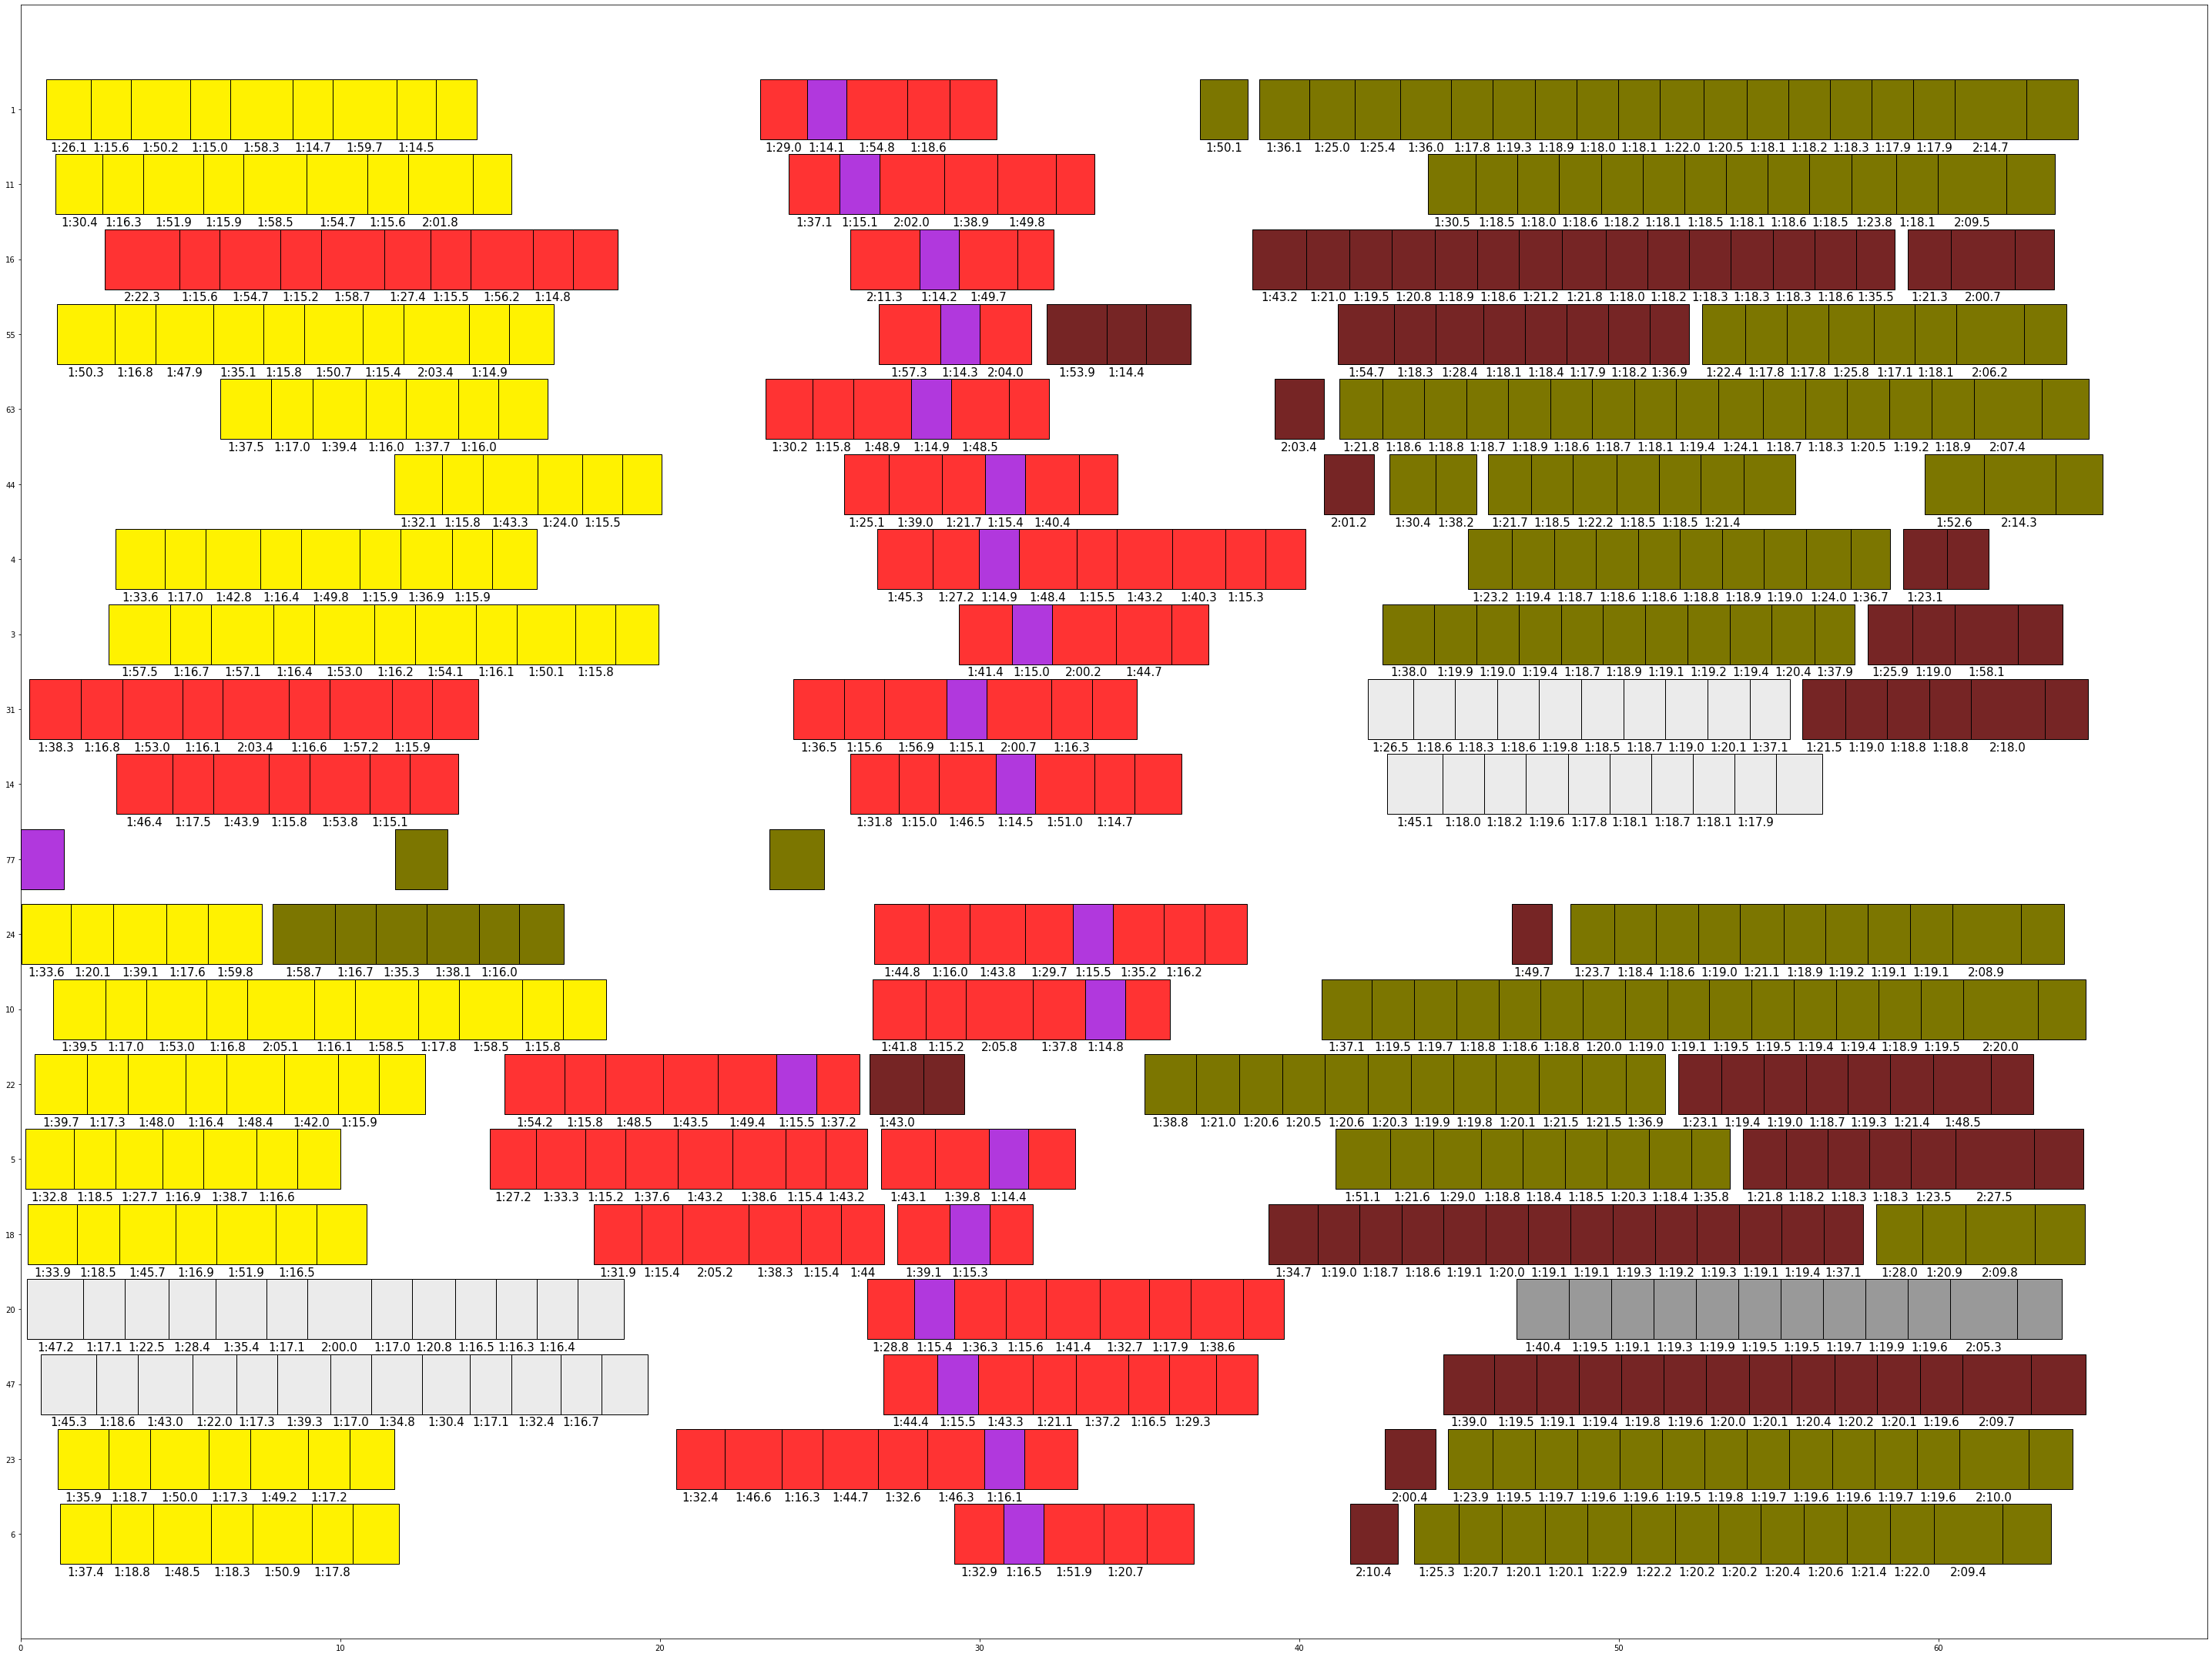

In [114]:
#drivers_to_visualize = ['1','11','4','3','6','23','27','18','10','22','14','31','24','77','47','20','63','44','55','16']
plt.rcParams["figure.figsize"] = [40,30]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
for driver in drivers_to_visualize:
    laps = gooddf.loc[gooddf['DriverNumber'] == driver]
    previous_stint_end = gooddf['StartTimes']
    for _, lap in laps.iterrows():
            
        plt.barh([driver],lap['LapTimes'],left = lap['StartTimes'], 
                 color = compound_colors[lap['Compound_Freshness']],
                 edgecolor = "black")

for bar, time in zip(ax.patches,prettylaps):
    ax.text((2*bar.get_x()+bar.get_width())/2 ,bar.get_y()-0.185, time,ha="center", va="bottom",fontsize=15)

fig.patch.set_facecolor('white')